# Timeseries data

In the current notebook, we will explore some of the nuances of the 'timeseries' dataset.  
This notebook will expand the EDA process for the individual datasets, focusing on investigating the interaction between different variables.  

The 'timeseries' dataset consists of the historical data of products orders. We track some measures like stocks, prices, competitor's prices, shipping values, order quantities over time, for 644 different products.

## TABLE OF CONTENTS

0. [Library and data imports](#library)  
1. [Dataset Exploration](#exploration)  
    1.1 Headers  
    1.2 Data types  
    1.3 Missing Values  
    1.4 Artificial columns  
    1.5 Summary statistics  
2. [Univariate Analysis](#univariate)  
    2.1 Prices (olist, competition, deltas)  
    2.2 Shipping (freight ratio)  
    2.3 Orders  
3. [Bivariate Analysis](#bivariate)  
    3.1 Price x Orders  
    3.2 Shipping x Orders  
    3.3 Product Attributes x Orders  
4. [Demand Sparsity](#sparsity)  
    4.1 Demonstrate sparsity of sales inside product_groups and types; show that we have few gtins per category  
5. [Product Group Analysis](#group)  
6. [Product GTIN analysis](#gtin)  
    6.1 Makeup Kit  

<a name="library"></a>
### 0 - Imports and reading the data

Let's import some packages and read the data.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


from matplotlib.dates import DateFormatter

In [47]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

%matplotlib inline

In [66]:
df = pd.read_csv('https://bsa-correlation-one.s3.amazonaws.com/timeseries644.csv', dtype={'product_gtin':'str'})
#df = pd.read_csv('../data/timeseries644.csv', dtype={'product_gtin':'str'})

<a name="exploration"></a>
### 1. Dataset exploration

At first, let's explore a few of the dataset's attributes. It is important to understand some of the column's information, data types, missing values and major statistics.


#### 1.1 Dataset Headers:

Each row of the dataset consists of the following information, for a given date: a product (gtin), the competition price and olist's price, the commission rates, the number of sales (orders), the product type and group, stock information and product's name and description.

In [12]:
df.head(3)

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description
0,2016-10-03,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
1,2016-10-04,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...
2,2016-10-05,7909389107160,169.9,179.9,NaN,NaN,NaN,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...


#### 1.2 Dataset info:

We have 299941 rows, with 21 columns. Most of the columns are complete, but notice that freight_value and commission columns have only 6.26% of the rows with information (18875). This information is only available when orders were created for a given product, on any given day.  
Also, product_type and group are present in 71.4% of the rows (214135). This means that roughly 30% of the products were not being sold in 1Q of 2020, when the categorization system was created.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299941 entries, 0 to 299940
Data columns (total 21 columns):
date                        299941 non-null object
product_gtin                299941 non-null object
competition_price           299941 non-null float64
price                       299941 non-null float64
freight_value               18775 non-null float64
commission_product_olist    18775 non-null float64
commission_freight_olist    18775 non-null float64
orders                      299941 non-null float64
product_type                214135 non-null object
product_type_group          214135 non-null object
stock_max                   299941 non-null float64
stock_min                   299941 non-null float64
stock_avg                   299941 non-null float64
price_max                   299941 non-null float64
price_min                   299941 non-null float64
price_avg                   299941 non-null float64
offer_max                   299941 non-null float64
offer_min   

#### 1.3 Missing values:

We can observe that freight value (which is the amount of shipping that was paid by the final customer) and commission_values are missing. Those columns will be dealt with later.

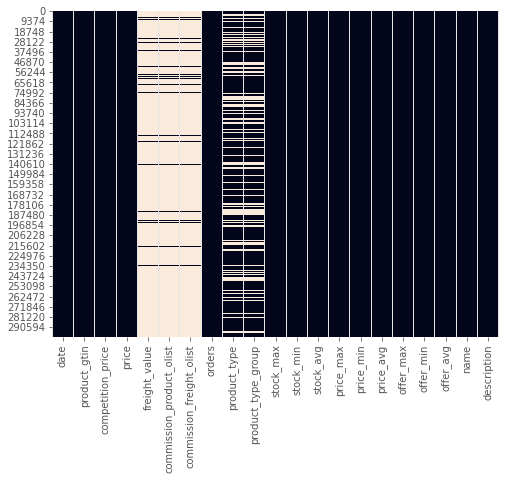

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

#### 1.4 Artificial columns and missing values:

Let's fill the empty values when needed and create some other columns that might be interesting to our analysis.  

Missing values:
- commissions: The empty commission rows will be filled with 0.20, since it is olist's default commision.

Artificial columns:
- freight_ratio: the ratio between shipping prices and the product's value. This might be problematic for product's that did not have any sales. This could be solved in a few weeks, since olist is preparing its shipping quotes historical database.  
- delta_price: percentual price difference between olist's price and competitor's price.

In [67]:
# Missing Values:

df[['commission_product_olist','commission_freight_olist']] = df[['commission_product_olist','commission_freight_olist']].fillna(value=0.20)

In [72]:
# Artificial columns:

### Freight ratio:
def freight_ratio(row):
    shipping = row['freight_value']
    price = row['price']
    if np.isnan(shipping):
        ratio = np.nan
    else:
        ratio = round(shipping / price, 3)
    
    return ratio


df['freight_ratio'] = df.apply(freight_ratio, axis=1)
#df['freight_ratio'] = df.freight_ratio.fillna(value=df.freight_ratio.mean())


### Delta price
df['delta_price'] = (df.price.values / df.competition_price.values) - 1

In [69]:
df.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,name,description,delta_price
0,2016-10-03,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.058858
1,2016-10-04,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.058858
2,2016-10-05,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.058858
3,2016-10-06,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.058858
4,2016-10-07,7909389107160,169.9,179.9,NaN,0.2,0.2,0.0,Prato giratório,utilidades_domesticas,0.0,0.0,0.0,179.9,179.9,179.9,179.9,179.9,179.9,Prato Giratório 80 cm em Madeira Laminado,Prato Giratório para Mesa Sala de Jantar;\nDim...,0.058858


#### 1.5 Summary Statistics:

From the summary statistics table below, we can observe a few interesting patterns:  
- For olist and competition prices, we observe similar values for every statistic, with olist prices apparently being slightly higher.  
- For commisions (over products and freight value), we see a similar mean and quartiles values. Olist's default commision is set to 0.20.  
- The orders column, which may be the most important for our analysis, we notice that most of the days have zero orders. This indicates a significant sparsity in our orders.
- For delta price, we observe that olist's price is, on average, 3% higher than its competitors'. One major issue with the data gathering process is that some of the competitor's prices are olist's prices itself. This happens when olist is the only vendor for a given product, or has the lowest price in the marketplace.

In [18]:
df.describe().round(2)

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,freight_ratio,delta_price
count,299941.00,299941.00,18775.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00,299941.00
mean,225.83,230.60,21.43,0.20,0.20,0.14,947.99,781.91,866.69,259.58,256.31,258.45,232.73,228.59,230.71,0.29,0.03
std,385.85,397.31,18.14,0.00,0.01,1.00,11724.94,11062.90,11301.07,433.64,430.36,432.76,401.33,393.73,397.47,0.06,0.15
min,6.99,6.97,0.00,0.09,0.00,0.00,0.00,0.00,0.00,6.99,6.99,6.99,6.99,6.92,6.97,0.00,-0.87
25%,65.00,65.00,12.16,0.20,0.20,0.00,5.00,1.00,4.00,79.00,76.80,78.47,65.81,64.99,65.00,0.29,0.00
50%,129.99,134.90,18.12,0.20,0.20,0.00,14.00,5.00,11.38,150.64,150.00,150.00,137.99,134.00,134.90,0.29,0.00
75%,239.90,240.00,25.08,0.20,0.20,0.00,99.00,80.00,97.00,288.80,279.99,282.00,243.99,239.99,240.00,0.29,0.01
max,7406.30,7387.78,344.70,0.25,0.25,91.00,246225.00,246225.00,246225.00,7406.30,7406.30,7406.30,7406.30,7332.24,7387.78,3.29,5.07


<a name="univariate"></a>
### 2. Univariate analysis

We now explore some of our variables behaviours, most notably:  
- prices (competitor's, olist's and delta)
- shipping values (freight_values and freight_ratio)
- product types and groups (categorical)
- orders

#### 2.1 Prices

We see below how olist's and its competitors match overall. The prices are highly skewed, so we display them log transformed as well.  
The behavior of olist's prices is very similar to its competitors' prices. On the delta prices plot, we observe that most of prices differences is close to 0%. We also observe that olist's prices tend to be a little bit higher then its competitors'.

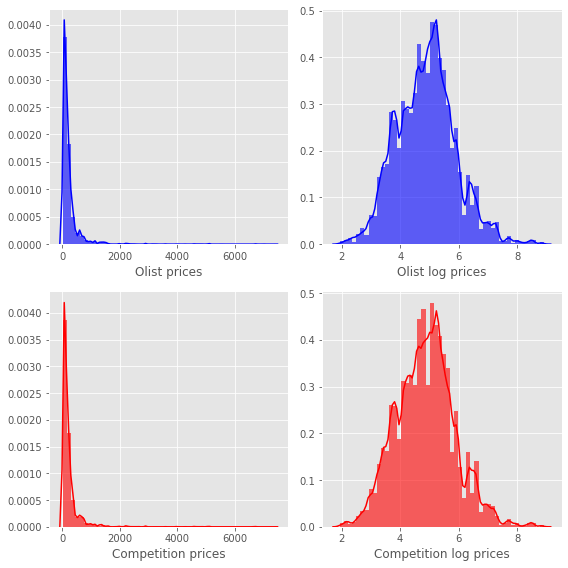

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

sns.distplot(df.price, hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0][0])
ax[0][0].set_xlabel("Olist prices")
sns.distplot(np.log(df.price), hist=True, kde=True, color='blue', hist_kws=dict(alpha=0.6), ax=ax[0][1])
ax[0][1].set_xlabel("Olist log prices")

sns.distplot(df.competition_price, hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1][0])
ax[1][0].set_xlabel("Competition prices")
sns.distplot(np.log(df.competition_price), hist=True, kde=True, color='red', hist_kws=dict(alpha=0.6), ax=ax[1][1])
ax[1][1].set_xlabel("Competition log prices")

plt.tight_layout()
plt.show()

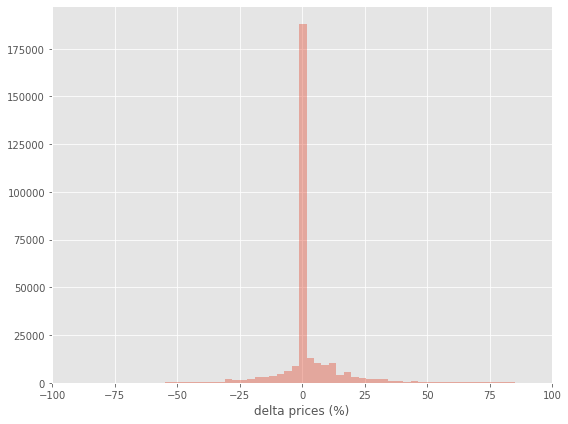

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df.delta_price*100, kde=False, bins=200, ax=ax)
plt.xlabel('delta prices (%)')
plt.xlim((-100,100))
plt.tight_layout()
plt.show()

#### 2.2 Shipping: values and ratio

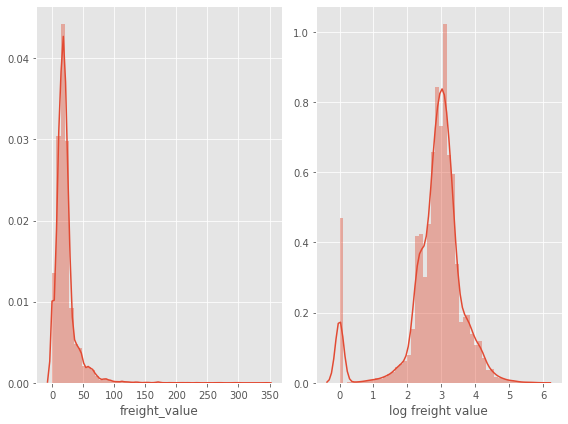

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(8,6))

sns.distplot(df.freight_value, ax=ax[0])

sns.distplot(np.log(df.freight_value+1), ax=ax[1])
ax[1].set_xlabel('log freight value')

plt.tight_layout()

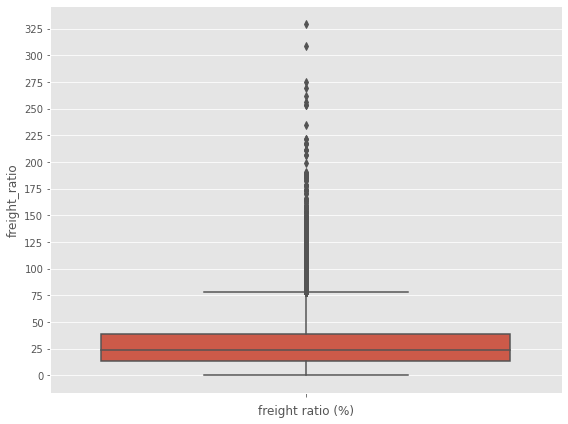

count    18775.00
mean        29.49
std         25.24
min          0.00
25%         12.95
50%         23.20
75%         38.90
max        329.40
Name: freight_ratio, dtype: float64


In [84]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(y=df.freight_ratio*100, ax=ax)
plt.xlabel('freight ratio (%)')
plt.yticks(range(0,350,25))
plt.tight_layout()
plt.show()

print((df.freight_ratio*100).describe().round(2))

#### 2.3 Orders

TODO

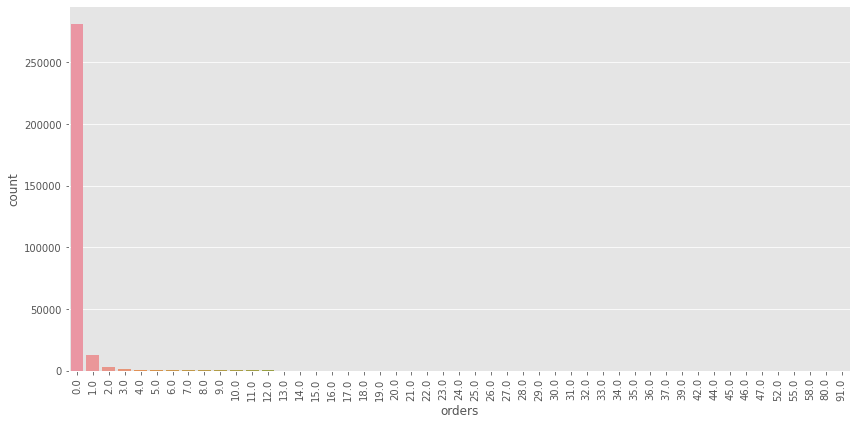

In [115]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(df.orders.round(0), ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

<a name="bivariate"></a>
### 3. Bivariate Analysis

Our main focus of this EDA is to understand what drives order quantities.  
1. Freight Value (how does free shipping impact our sales)  
2. Relationship to competitor's prices

Let's create 2 different columns to map some relationships between variables:  

- delta_price: price difference (%) between olist's price and our competition's price;
- freight_ratio: ratio between freight value and product's price. When freight_value is NaN, it will be assumed as 16%

Now, let's see how orders are correlated with other variables

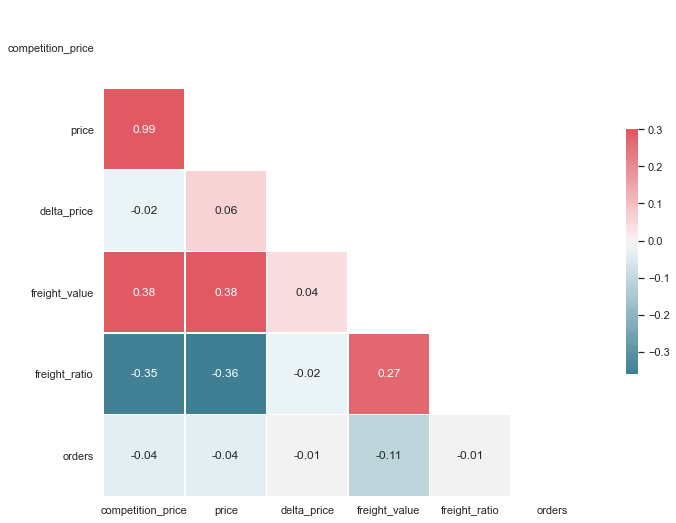

In [126]:
sns.set(style="white")

corr = df[['competition_price','price','delta_price',
           'freight_value','freight_ratio','orders']].corr().round(2)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

#### 3.1 Prices x Orders

<a name="sparsity"></a>
### 4. Demand sparsity

Olist offers many long-tail products, i.e. hard to find products, that are sold in low volumes to many customers. To mitigate this problem, let's first analyze the top selling products/categories.

##### Products

In [127]:
df['days'] = 1

In [128]:
sparsity = df.groupby('product_gtin')[['orders','days']].sum().reset_index()

sparsity['orders_per_day'] = sparsity['orders'].values / sparsity['days'].values

sparsity = sparsity.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity.describe()

,orders,days,orders_per_day
count,644.000000,644.000000,644.000000
mean,63.119565,465.746894,0.135026
std,211.872485,326.266647,0.427785
min,1.000000,56.000000,0.001014
25%,4.000000,208.750000,0.013202
50%,13.000000,374.500000,0.037566
75%,44.250000,631.750000,0.099235
max,2859.000000,1360.000000,5.529255


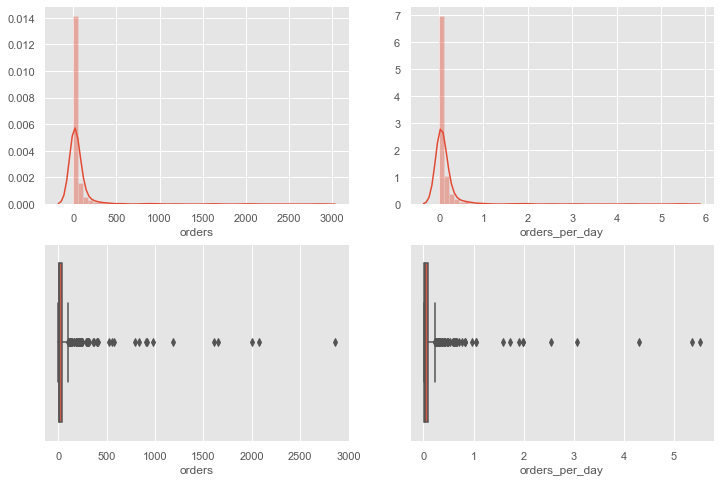

In [130]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.distplot(sparsity.orders, ax=ax[0][0])
sns.distplot(sparsity.orders_per_day, ax=ax[0][1])

sns.boxplot(sparsity.orders, ax=ax[1][0])
sns.boxplot(sparsity.orders_per_day, ax=ax[1][1])

##### Product types

In [131]:
sparsity_ty = df.groupby('product_type')[['orders','days']].sum().reset_index()

sparsity_ty['orders_per_day'] = sparsity_ty['orders'].values / sparsity_ty['days'].values

sparsity_ty = sparsity_ty.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_ty.describe()

,orders,days,orders_per_day
count,250.000000,250.000000,250.000000
mean,122.288000,856.540000,0.157888
std,326.208432,997.616831,0.450496
min,1.000000,77.000000,0.001561
25%,7.000000,315.000000,0.015742
50%,25.500000,612.500000,0.042047
75%,89.750000,1107.000000,0.117745
max,2874.000000,8065.000000,5.529255


In [132]:
sparsity_ty.head(5)

,product_type,orders,days,orders_per_day
0,Lanterna,2874.0,1384,2.076590
1,Kit maquiagem,2079.0,376,5.529255
2,Transformador de energia,1999.0,1151,1.736751
3,Suporte para tv,1692.0,1357,1.246868
4,Carregador para celular e tablet,1652.0,866,1.907621


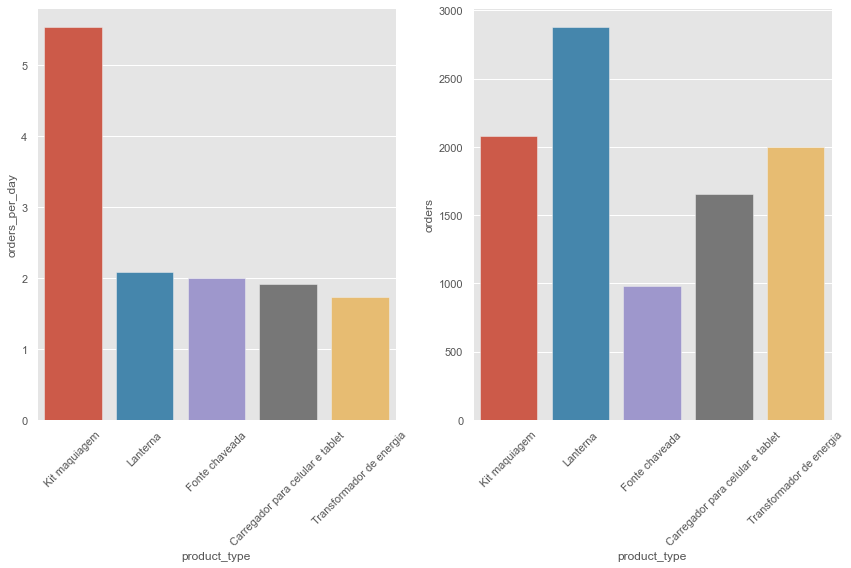

In [133]:
temp = sparsity_ty.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type.head(),rotation=45)


plt.tight_layout()

plt.show()

##### Product groups

In [134]:
sparsity_gr = df.groupby('product_type_group')[['orders','days']].sum().reset_index()

sparsity_gr['orders_per_day'] = sparsity_gr['orders'].values / sparsity_gr['days'].values

sparsity_gr = sparsity_gr.sort_values(by=['orders','orders_per_day'], ascending=False).reset_index(drop=True)

sparsity_gr.describe()

,orders,days,orders_per_day
count,38.000000,38.000000,38.000000
mean,804.526316,5635.131579,0.166637
std,1297.394181,5974.893776,0.296557
min,2.000000,342.000000,0.001561
25%,74.500000,1281.000000,0.031622
50%,209.500000,3721.000000,0.062956
75%,689.000000,7236.750000,0.154663
max,6129.000000,28479.000000,1.662738


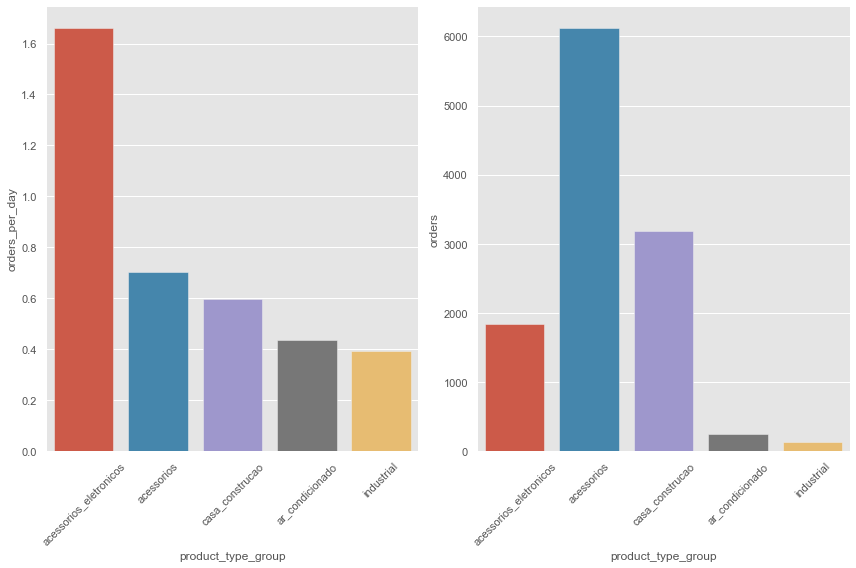

In [135]:
temp = sparsity_gr.sort_values(by='orders_per_day', ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))


sns.barplot(temp.product_type_group.head(), temp.orders_per_day.head(), ax=ax[0])
sns.barplot(temp.product_type_group.head(), temp.orders.head(), ax=ax[1])

ax[0].set_xticklabels(temp.product_type_group.head(),rotation=45)
ax[1].set_xticklabels(temp.product_type_group.head(),rotation=45)


plt.tight_layout()

plt.show()

<a name="gtin"></a>
### 6. GTIN Analysis

#### 6.1 Product 1: Make-up kit
Let's choose a single product_type: makeup kit.  
It contains the largest average of orders per day (~5)

In [169]:
makeup = df[df.product_type == 'Kit maquiagem'].copy().reset_index(drop=True)

In [137]:
makeup.product_gtin.nunique()

1

In [138]:
makeup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 24 columns):
date                        376 non-null object
product_gtin                376 non-null object
competition_price           376 non-null float64
price                       376 non-null float64
freight_value               281 non-null float64
commission_product_olist    376 non-null float64
commission_freight_olist    376 non-null float64
orders                      376 non-null float64
product_type                376 non-null object
product_type_group          376 non-null object
stock_max                   376 non-null float64
stock_min                   376 non-null float64
stock_avg                   376 non-null float64
price_max                   376 non-null float64
price_min                   376 non-null float64
price_avg                   376 non-null float64
offer_max                   376 non-null float64
offer_min                   376 non-null float64
offer_avg        

In [139]:
makeup.describe()

,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,delta_price,freight_ratio,days
count,376.000000,376.000000,281.000000,376.000000,376.000000,376.000000,376.00000,376.000000,376.000000,3.760000e+02,3.760000e+02,3.760000e+02,376.000000,376.000000,376.000000,3.760000e+02,281.000000,376.0
mean,135.058644,140.784185,28.576118,0.184884,0.184884,5.529255,636.68883,595.071809,616.400485,1.699000e+02,1.699000e+02,1.699000e+02,141.655319,140.493085,140.881673,4.493648e-02,0.203224,1.0
std,9.027437,10.259440,10.491495,0.019158,0.019158,6.194983,410.08069,433.051680,418.349112,2.845958e-14,2.845958e-14,9.864149e-14,11.196605,10.456098,10.235680,7.776052e-02,0.079169,0.0
min,105.510000,117.486552,0.000000,0.160000,0.160000,0.000000,5.00000,0.000000,5.000000,1.699000e+02,1.699000e+02,1.699000e+02,119.900000,119.900000,119.900000,-2.942908e-01,0.000000,1.0
25%,131.660000,134.900000,23.050000,0.160000,0.160000,0.000000,303.25000,248.000000,268.574761,1.699000e+02,1.699000e+02,1.699000e+02,134.900000,134.900000,134.900000,0.000000e+00,0.158000,1.0
50%,134.900000,134.900000,27.888333,0.200000,0.200000,4.000000,493.00000,489.000000,489.500000,1.699000e+02,1.699000e+02,1.699000e+02,134.900000,134.900000,134.900000,2.220446e-16,0.192000,1.0
75%,137.150000,153.233333,33.032500,0.200000,0.200000,8.000000,985.25000,952.500000,959.931818,1.699000e+02,1.699000e+02,1.699000e+02,154.900000,154.900000,154.900000,7.971041e-02,0.245000,1.0
max,169.900000,156.900000,64.470000,0.200000,0.200000,37.000000,1501.00000,1488.000000,1492.833333,1.699000e+02,1.699000e+02,1.699000e+02,169.900000,156.900000,156.900000,2.710592e-01,0.457000,1.0


In [140]:
makeup.corr().round(3)[['orders']]

,orders
competition_price,-0.316
price,-0.116
freight_value,-0.334
commission_product_olist,-0.287
commission_freight_olist,-0.287
orders,1.000
stock_max,0.159
stock_min,0.146
stock_avg,0.173
price_max,0.000


Now, we see that both freight ratio and freight value columns have negative correlations with orders. That could indicate that offering free shipping might have a bigger impact on sales.  
If we observe the delta_price correlation we might consider that having a higher price than our competitors may not hinder our competitiveness.  

Let's analyze our timeseries behavior:

In [142]:
columns = ['competition_price', 'price', 'freight_value','orders', 'stock_max'] 

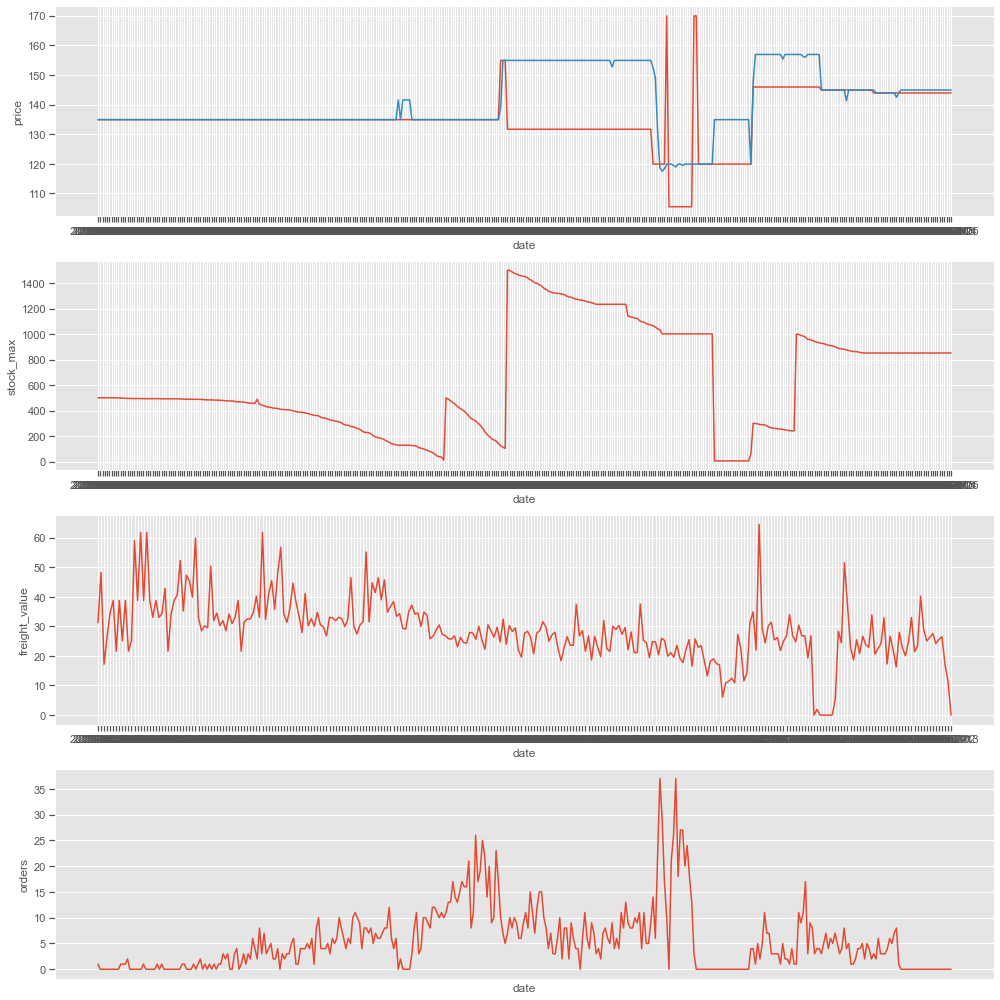

In [167]:
sns.set_style()

fig, ax = plt.subplots(nrows=4, figsize=(14,14))

sns.lineplot(x=makeup.index, y=makeup['competition_price'], ax=ax[0])
sns.lineplot(x=makeup.index, y=makeup['price'], ax=ax[0])


sns.lineplot(x=makeup.index, y=makeup['stock_max'], ax=ax[1])

sns.lineplot(x=makeup.index, y=makeup['freight_value'], ax=ax[2])

sns.lineplot(x=makeup.index, y=makeup['orders'], ax=ax[3])


plt.tight_layout()

Looking at the above plot, we can observe a few interesting things: the period in which we have the most sales is a few weeks before Christmas; The period without sales from mid December 2019 to January is the same period when our stocks are the lowest (around 5 units); We observe that from Jan 28th to Feb 3, there was a small rise in sales when the shipping values were 0 (free shipping); 

In [173]:
makeup.name[0]

'Maleta Kit Maquiagem Profissional Completa Ruby Rose'

In [174]:
makeup.product_gtin[0]

'7899495703106'